# MorDIFF implementation

In [5]:
from templates import *
from torchvision import transforms
from PIL import Image
import torch
import numpy as np
from torch.functional import F
import matplotlib.pyplot as plt
import shutil

In [6]:
# load the model
device = 'cuda:0'
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device)

# images to fuse: needs to be aligned
# image1 = 'imgs_interpolate/sandy_dst-align/sandy.png'
# image2 = 'imgs_interpolate/sandy_dst-align/dst_0.9.png'
#image1 = 'imgs_interpolate/sandy_dst-crop/0.png'
#image2 = 'imgs_interpolate/sandy_dst-crop/1.png'
image1 = 'imgs_interpolate/profile_256/001_03.png'
image2 = 'imgs_interpolate/profile_256/002_02.png'
outfolder = 'results/mordiff'



Global seed set to 0


Model params: 160.69 M


In [7]:
image_size = conf.img_size # 256

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

to_pil_image = transforms.ToPILImage()

def load_image(path):
    img = Image.open(path)
    # if the image is 'rgba'!
    img = img.convert('RGB')

    assert img.size[0] == img.size[1] == 256

    if transform is not None:
        img = transform(img)

    return img

img1 = load_image(image1)
img2 = load_image(image2)

batch = torch.stack([
    img1, 
    img2
])



In [8]:
cond = model.encode(batch.to(device))

T = 250
xT = model.encode_stochastic(batch.to(device), cond, T=T)

alpha = torch.tensor([0.0, 0.5, 1.0]).to(cond.device)
intp = cond[0][None] * (1 - alpha[:, None]) + cond[1][None] * alpha[:, None]

def cos(a, b):
    a = a.view(-1)
    b = b.view(-1)
    a = F.normalize(a, dim=0)
    b = F.normalize(b, dim=0)
    return (a * b).sum()

theta = torch.arccos(cos(xT[0], xT[1]))
x_shape = xT[0].shape
intp_x = (torch.sin((1 - alpha[:, None]) * theta) * xT[0].flatten(0, 2)[None] + torch.sin(alpha[:, None] * theta) * xT[1].flatten(0, 2)[None]) / torch.sin(theta)
intp_x = intp_x.view(-1, *x_shape)

pred = model.render(intp_x, intp, T=20)



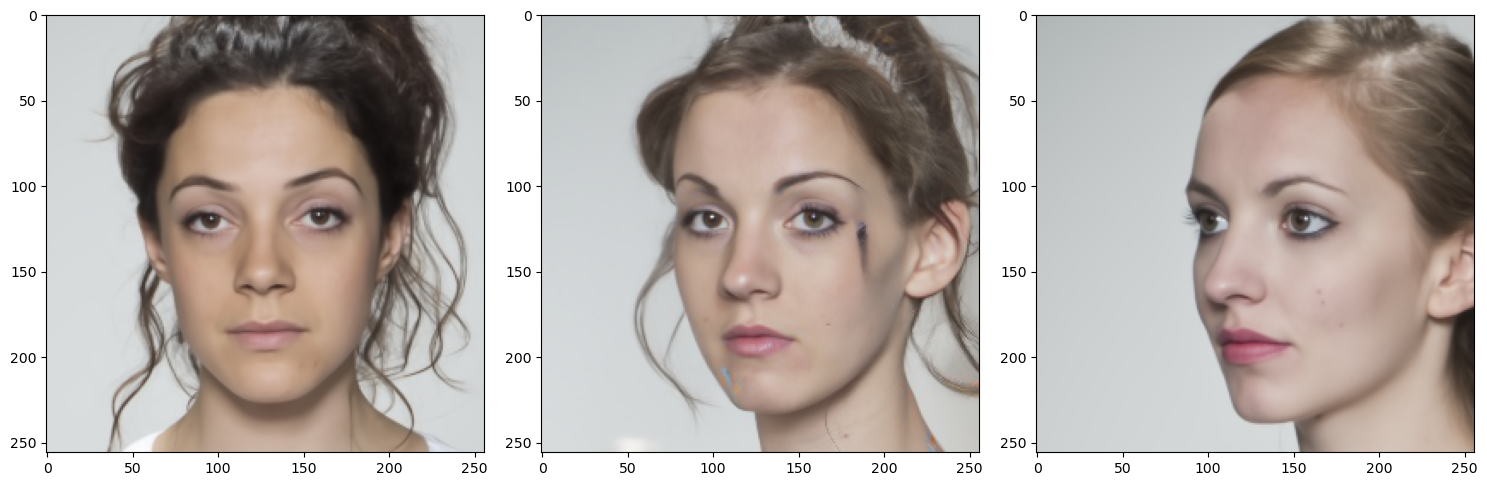

In [9]:
# torch.manual_seed(1)
#fig, ax = plt.subplots(1, 10, figsize=(5*10, 5))
fig, ax = plt.subplots(1, 3, figsize=(5*3, 5))
for i in range(len(alpha)):
    ax[i].imshow(pred[i].permute(1, 2, 0).cpu())

plt.tight_layout()
plt.show()

In [10]:
name1 = image1.split(".")[0].split("/")[-1]
name2 = image2.split(".")[0].split("/")[-1]
result_name = f"morphed_{name1}_and_{name2}"

exp_outfolder = os.path.join(outfolder, result_name)
if not os.path.exists(exp_outfolder):
    os.makedirs(exp_outfolder)

#plt.savefig(os.path.join(outfolder, f"comparison_{name1}_and_{name2}.png"))

#plt.close("all")
shutil.copy(image1, os.path.join(exp_outfolder, f"{name1}.png"))
shutil.copy(image2, os.path.join(exp_outfolder, f"{name2}.png"))

pred_img = to_pil_image(pred[1].cpu())
pred_img.save(os.path.join(exp_outfolder, f"{result_name}.png"))